### K-means
No predice nada. No se dividen los datos en entrenamiento y test.

##### Clustering de Clientes de Supermercado

Agrupar clientes según su comportamiento de compra:

- `gasto_mensual` (en pesos)
- `visitas_por_mes`
- `productos_distintos` (variedad)
- `porcentaje_ofertas` (% de compras en promo)

El modelo descubre por si solo grupos para luego:

- Enviar promos personalizadas
- Fidelizar clientes
- Optimizar stock

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')

##### Creación de 9010 - 4 consumidores 

In [8]:
np.random.seed(42)
n = 3002 # x 3 grupos

# Grupo 1: Clientes AHORRATIVOS (poco gasto, muchas visitas, buscan ofertas)
ahorrativos = pd.DataFrame({
    'gasto_mensual': np.random.normal(25000, 8000, n),
    'visitas_por_mes': np.random.normal(12, 3, n),
    'productos_distintos': np.random.normal(15, 5, n),
    'porcentaje_ofertas': np.random.normal(75, 15, n)
})

# Grupo 2: Clientes FAMILIARES (gasto medio-alto, visitas regulares, variedad)
familiares = pd.DataFrame({
    'gasto_mensual': np.random.normal(75000, 15000, n),
    'visitas_por_mes': np.random.normal(6, 2, n),
    'productos_distintos': np.random.normal(40, 10, n),
    'porcentaje_ofertas': np.random.normal(30, 10, n)
})

# Grupo 3: Clientes PREMIUM (alto gasto, pocas visitas, compran marcas)
premium = pd.DataFrame({
    'gasto_mensual': np.random.normal(150000, 30000, n),
    'visitas_por_mes': np.random.normal(3, 1, n),
    'productos_distintos': np.random.normal(25, 8, n),
    'porcentaje_ofertas': np.random.normal(10, 5, n)
})

# Unir todo
data = pd.concat([ahorrativos, familiares, premium], ignore_index=True)
data = data.round(0).astype(int)
data = data.clip(lower=0)

print(f"\nTotal clientes: {len(data)}")

data.head()


Total clientes: 9006


,gasto_mensual,visitas_por_mes,productos_distintos,porcentaje_ofertas
0,28974,11,14,72
1,23894,18,19,90
2,30182,14,13,80
3,37184,8,7,92
4,23127,13,21,80


##### Visualización exploratoria

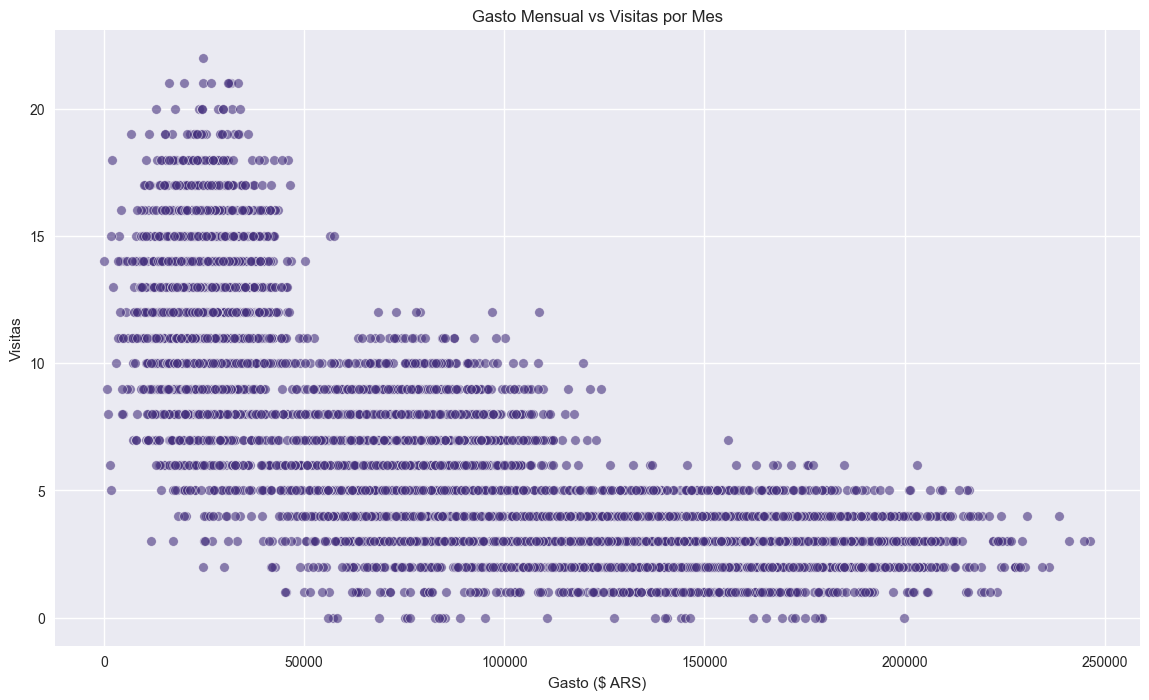

In [29]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=data, x='gasto_mensual', y='visitas_por_mes', alpha=0.6)
plt.title('Gasto Mensual vs Visitas por Mes')
plt.xlabel('Gasto ($ ARS)')
plt.ylabel('Visitas')

plt.show()

##### Escalar datos (método Juán Pablo)

In [11]:
scaler = StandardScaler() # z-score, esto optimiza el modelo
data_scaled = scaler.fit_transform(data)

df = pd.DataFrame(data_scaled, columns=data.columns).head().round(2)
df

,gasto_mensual,visitas_por_mes,productos_distintos,porcentaje_ofertas
0,-1.00,0.94,-0.97,1.16
1,-1.09,2.57,-0.59,1.78
2,-0.97,1.64,-1.05,1.44
3,-0.85,0.24,-1.51,1.85
4,-1.10,1.40,-0.43,1.44


### -> Inicio de nota al margen

##### Centroide (hablando de esto me voy a morir soltero)
Un centroide es el "centro" o el punto promedio de un grupo (cluster) en K-Means. Tienes un montón de puntos que forman un grupo. El centroide es el punto exacto que está en el medio de ese grupo, calculado como el promedio de todas las coordenadas de los puntos que pertenecen al cluster.

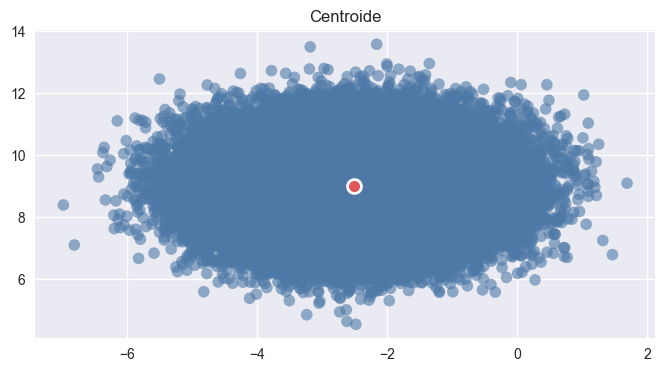

In [15]:
X, _ = make_blobs(n_samples=100000, centers=1, random_state=42)  
kmeans = KMeans(n_clusters=1, n_init='auto')
kmeans.fit(X)

plt.figure(figsize=(8,4))
plt.scatter(X[:,0], X[:,1], c='#4e79a7', s=70, alpha=0.6, edgecolors='none')
plt.scatter(kmeans.cluster_centers_[0,0], kmeans.cluster_centers_[0,1],
    c='#e15759',      
    marker='o',       
    s=100,            
    edgecolors='white',
    linewidth=2,
    zorder=5)

plt.title('Centroide')
plt.show()

### -> Fin nota al margen

##### Método del codo
El método del codo (Elbow Method) es una técnica para decidir cuántos grupos (clusters) usar en K-Means. Por cada K (grupo) se calcula la inercia o suma de las distancias al centroide (distancia al centro de cada grupo o también error). Se trata de elegir el número de k donde la curva forma un “codo”, es decir, donde añadir más clusters ya no reduce mucho el error.

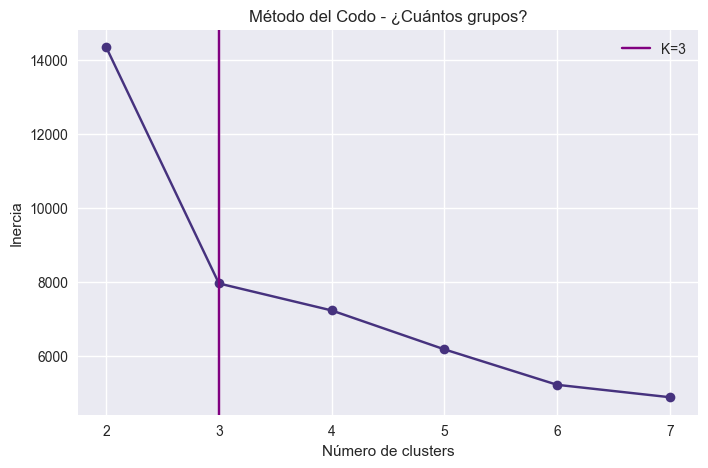

In [16]:
inertia = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo - ¿Cuántos grupos?')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.axvline(3, color='purple', linestyle='-', label='K=3')
plt.legend()
plt.show()

##### Aplicar K-Means

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)

data['cluster'] = kmeans.labels_

print("Clientes por grupo:")
print()
print(data['cluster'].value_counts().sort_index())

Clientes por grupo:

cluster
0    2989
1    3001
2    3016
Name: count, dtype: int64


##### Visualizar grupos

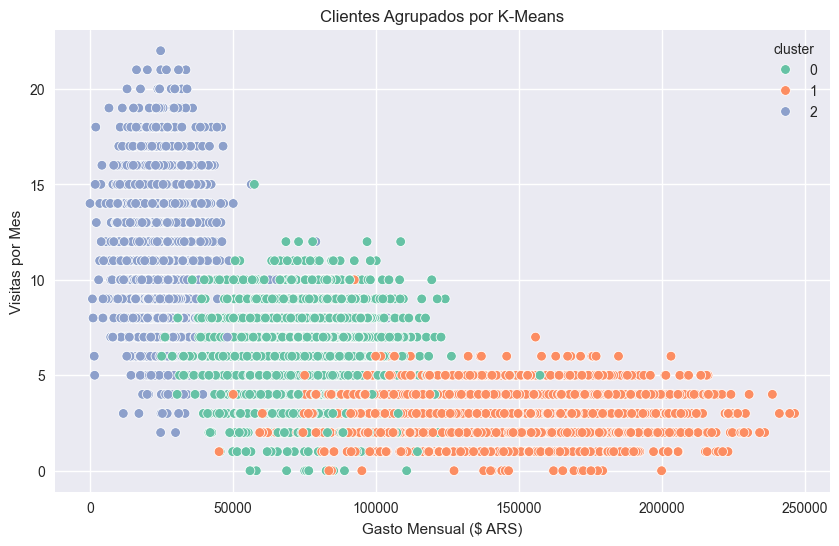

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x='gasto_mensual', y='visitas_por_mes', hue='cluster', palette='Set2')
plt.title('Clientes Agrupados por K-Means')
plt.xlabel('Gasto Mensual ($ ARS)')
plt.ylabel('Visitas por Mes')
plt.show()

##### Interpretación de los grupos

In [23]:
print("Promedio por grupo:")
print()
df = data.groupby('cluster').mean().round(0)
df

Promedio por grupo:



,gasto_mensual,visitas_por_mes,productos_distintos,porcentaje_ofertas
cluster,,,,
0,75926.0,6.0,41.0,30.0
1,149934.0,3.0,24.0,10.0
2,25467.0,12.0,15.0,75.0


##### Estrategias MKT por grupo (ejemplos)
- AHORRATIVOS: Enviar cupones 2x1, promos semanales, alertas de ofertas.
- FAMILIARES: Packs familiares, descuentos por volumen, programa de puntos.
- PREMIUM: Productos importados, degustaciones, delivery gratis, tarjeta oro.

##### Métrica de evaluación Silhouette
Si el resultado es bueno indica que el modelo es bueno. Y el número de clusters K es el óptimo.

![](img/silueta.png)

In [25]:
print(f"Silhouette: {silhouette_score(data_scaled, data['cluster']):.3f}")

Silhouette: 0.517


##### Métrica de evaluación Calinski-Harabasz
Si el resultado es bueno indica que el modelo es bueno. Si los clusters están hiper compactos por dentro y súper separados entre sí.

![](img/calinski.png)

In [26]:
print(f"Calinski-Harabasz: {calinski_harabasz_score(data_scaled, data['cluster']):.0f}")

Calinski-Harabasz: 15869


##### Clasificar un cliente nuevo

In [21]:
nuevo_cliente = pd.DataFrame({
    'gasto_mensual': [45000],
    'visitas_por_mes': [10],
    'productos_distintos': [20],
    'porcentaje_ofertas': [65]
})

nuevo_scaled = scaler.transform(nuevo_cliente)
cluster = kmeans.predict(nuevo_scaled)[0]

grupos_supermercado = {
    0: "Familiares",
    1: "Premium",
    2: "Ahorrativos",
}

print(f"→ Pertenece al Cluster {cluster} → **{grupos_supermercado[cluster]}**")

→ Pertenece al Cluster 2 → **Ahorrativos**
